# Imports

In [90]:
!pip install transformers

In [91]:
import os
import h5py
import json
import numpy as np
from transformers import DistilBertTokenizer, DistilBertModel
import cv2
from sklearn.model_selection import train_test_split

import keras as keras
from keras.models import Model
from keras import layers as layers
from keras.initializers import glorot_uniform
from keras import backend as K
K.set_image_data_format('channels_last')
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model

import nltk
import string
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Reading data

In [92]:
# from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)
# base_path = '/content/gdrive/My Drive/iust/miniVQA/'
# output_path = base_path
base_path = '/kaggle/input/medical-visual-question-answering/'
image_path = base_path + '/VQA_RAD Image Folder'
output_path = '/kaggle/working/'

In [93]:
with open(base_path + "/VQA_RAD Dataset Public.json", "r") as f:
    rad_json_data = json.load(f)
rad_json_data = [d for d in rad_json_data if d["answer_type"] != "CLOSED"]

In [94]:
print(rad_json_data[0])

{'qid': 3, 'phrase_type': 'freeform', 'qid_linked_id': '0e90b6bc-265f-490b-a039-509b9907a3cb', 'image_case_url': 'https://medpix.nlm.nih.gov/case?id=19aa8a2b-35fb-4d90-973d-ccc3859df66e', 'image_name': 'synpic28602.jpg', 'image_organ': 'CHEST', 'evaluation': 'given', 'question': 'What type of imaging does this not represent?', 'question_rephrase': 'NULL', 'question_relation': 'NULL', 'question_frame': 'NULL', 'question_type': 'MODALITY', 'answer': 'ultrasound', 'answer_type': 'OPEN'}


In [95]:
print(len(rad_json_data))

951


## Dataset Structure
* qid: question id
* phrase_type: freeform / para / test-freeform / test-paraphrase
* qid_linked_id: unique identifier for every pair of free-form and paraphrased questions that can be used to link original and rephrasing
* image_case_url: image url in medpix
* image_name
* image_organ (e.g. HEAD)
* evaluation: evaluated = two clinical annotators reviewed image and QA pair, not evaluated = one clinical annotator
* question
* question_rephrase: rephrasing of ‘question’, can be freeform or para, linked through qid_linked_id
* question_relation: rephrasing of ‘question’ following a templated structure
* question_type: MODALITY - PLANE - ORGAN (Organ System) - ABN (Abnormality) - PRES (Object/Condition Presence) - POS (Positional Reasoning) - COLOR - SIZE - ATTRIB (Attribute Other) - COUNT (Counting) - Other
* answer
* answer_type (e.g. CLOSED)

# Pretrained models

In [ ]:
distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

resnet50 = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3),
    )

# Preprocessings and data generators

## build vocab

In [96]:
answers_max_length = 5
questions_max_length = 10

In [97]:
# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

## Getting vocab

In [98]:
tokenizer(["tokens here"], return_tokens=True)

Keyword arguments {'return_tokens': True} not recognized.


{'input_ids': [[101, 19204, 2015, 2182, 102]], 'attention_mask': [[1, 1, 1, 1, 1]]}

In [99]:
train_json_data, valid_json_data = train_test_split(rad_json_data, test_size=0.1, random_state=42)

In [120]:
snow_stemmer = SnowballStemmer(language='english')
stop_words = set(stopwords.words('english'))
fdist = FreqDist()

def preprocess_text(text):
    tokens = word_tokenize(str(text).lower())
    tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]
    tokens = [snow_stemmer.stem(token) for token in tokens]
    return tokens

for data in train_json_data:
    tokens = preprocess_text(data["answer"])
    for token in tokens:
        fdist[token] += 1



vocab = list(fdist.keys())
vocab.append("<")
vocab.append(">")
vocab.append("unk")
vocab.insert(0, "")
wtoi = {w:i for i,w in enumerate(vocab)}
itow = dict(
    (i, w) for w, i in wtoi.items())

print("Built a vocab with the size of: ", len(vocab))

Built a vocab with the size of:  530


In [102]:
def load_images_from_list(pixel_x, pixel_y, img_names, folder_path=image_path):
    images_list = []

    for img in img_names:
        img_path = folder_path + "/" + img
        image = cv2.imread(img_path, 0)
        image = cv2.resize(
            image, (pixel_y, pixel_x), interpolation=cv2.INTER_AREA
        )  # resize image
        images_list.append(image)

    images_list_np = np.array(images_list)
    return images_list_np

In [118]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, json_data, batch_size):
        self.json_data = json_data
        self.batch_size = batch_size
        

    def __len__(self):
        return (np.ceil(len(self.json_data) / float(self.batch_size))).astype(int)
    
    def preprocess_text(self, texts, max_len):
        tokens = tokenizer(texts, max_length=max_len, truncation=True, padding='max_length', return_tensors="pt")
        outputs = distilbert(input_ids=tokens.input_ids).last_hidden_state
        return outputs.detach().numpy()
    
    def tokenize_answers(self, text):
        tokens = word_tokenize(str(text).lower())
        tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]
        tokens = [snow_stemmer.stem(token) for token in tokens]
        tokens.append(">")
        tokens.insert(0, "<")
        return tokens
    
    def preprocess_answers(self, answers):
        size = len(answers)
        new_answers = np.full((size, answers_max_length), wtoi[""], dtype='uint32')
        for i in range(size):
            tokens = self.tokenize_answers(answers[i])
            for j in range(len(tokens)):
                token = tokens[j]
                if j < answers_max_length:
                    index = wtoi.get(token, wtoi["unk"])
                    new_answers[i][j] = index
        
        return new_answers
    
    def get_decoder_target(self, answers):
        decoder_target_data = np.roll(
            to_categorical(answers, dtype="int8", num_classes=len(vocab)),
            axis=1, shift=-1
        )
        decoder_target_data[:,-1,0] = 1
        decoder_target_data[:,-1,1:] = wtoi[""]
        return decoder_target_data


    def __getitem__(self, idx):
        batch_data = self.json_data[
            idx * self.batch_size : (idx + 1) * self.batch_size
        ]
        batch_image_names = [d["image_name"] for d in batch_data]
        batch_images = load_images_from_list(224, 224, batch_image_names)
        batch_images = np.expand_dims(batch_images, axis=-1)
        batch_images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(batch_images), name=None)
        
        batch_questions = self.preprocess_text(
            [d["question"] for d in batch_data], questions_max_length
        )
        
        batch_answers = self.preprocess_answers([d["answer"] for d in batch_data])
        batch_target = self.get_decoder_target(batch_answers)
        
        
        return [
            [
                [batch_questions, batch_images], batch_answers
            ],
            batch_target
        ]


In [104]:
batch_size = 64

In [123]:
train_datagen = DataGenerator(train_json_data, batch_size)
valid_datagen = DataGenerator(valid_json_data, batch_size)

In [121]:
def one_hot_decode(encoded_seq):
  return [np.argmax(vector) for vector in encoded_seq]

for i in range(5):
  enc, target = train_datagen[0]
  inp, ans = enc
  
  print(ans[i], one_hot_decode(target[i]))

[527   1   2 528   0] [1, 2, 528, 0, 0]
[527   3 528   0   0] [3, 528, 0, 0, 0]
[527   4   5 528   0] [4, 5, 528, 0, 0]
[527   6 528   0   0] [6, 528, 0, 0, 0]
[527   7 528   0   0] [7, 528, 0, 0, 0]


## MFB Block

In [ ]:
class MFBBlock(layers.Layer):
    def __init__(self, drop_out_rate=0.2, factor_num=5, out_dim=20, **kwargs):
        self.drop_out_rate = drop_out_rate
        self.factor_num = factor_num
        self.out_dim = out_dim
        super(MFBBlock, self).__init__(**kwargs)

    def build(self, input_shape):
        super(MFBBlock, self).build(input_shape)

    def call(self, inputs):
        x, y = inputs
        # EXPAND
        exp1 = layers.Multiply()([x, y])
        exp2 = layers.Dropout(self.drop_out_rate)(exp1)

        reshape1 = layers.Reshape((-1, self.out_dim, self.factor_num))(exp2)
        
        # SQUEEZE
        sq1 = layers.AveragePooling2D(pool_size=self.factor_num, strides=self.factor_num)(reshape1)
        reshape2 = layers.Reshape((-1,))(sq1)
        # power normalization
        sq2 = layers.Lambda(lambda x: K.sign(x) * K.sqrt(K.abs(x)))(reshape2)
        # l2 normalization
        sq3 = layers.Lambda(lambda x: K.l2_normalize(x, axis=-1))(sq2)
        return sq3

In [134]:
embedding_size = 5
num_decoder_tokens = len(vocab)
decoder_state_len = 40

In [135]:
def get_vqa_model(q_input_shape, img_input_shape, max_q_length = 10, latent_dim = 1000, dropout_pct = 0,
                  q_feat_len = 768, classes_n = 64, img_feat_len = 1000, activation_function = 'tanh'):

    resnet50.trainable = False
    
    q_input = layers.Input(shape=q_input_shape, dtype='float32', name='q_feat')
    img_input = layers.Input((224, 224, 3), dtype='float32', name='img_input')
    img_feat = resnet50(img_input)
    img_feat = layers.Reshape((-1,), name='resnet50_out_reshape')(img_feat)

    encoder_inputs = [q_input, img_input]
    img_feat = layers.Dense(img_feat_len, name='img_dense_1')(img_feat)
    
    _, state_h, state_c = layers.LSTM(latent_dim, return_state=True, name='encoder_lstm_1')(q_input)
    state_h = MFBBlock()([state_h, img_feat])
    state_c = MFBBlock()([state_c, img_feat])
    encoder_states = [state_h, state_c]
    encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

    
    decoder_state_input_h = layers.Input(shape=(decoder_state_len,), name='decoder_state_input_h')
    decoder_state_input_c = layers.Input(shape=(decoder_state_len,), name='decoder_state_input_c')
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_inputs = layers.Input(shape=(None,), name='decoder_inputs')
    decoder_embed = layers.Embedding(num_decoder_tokens, embedding_size, mask_zero=True)
    
    d_x = decoder_embed(decoder_inputs)
    decoder_lstm = layers.LSTM(decoder_state_len, return_sequences=True, return_state=True, name='decoder_lstm')
    d_x, _, _ = decoder_lstm(d_x, initial_state=encoder_states)

    decoder_dense = layers.Dense(num_decoder_tokens)
    decoder_outputs = decoder_dense(d_x)
    decoder_outputs = layers.Activation('softmax')(decoder_outputs)

    decoder_embed_inf = decoder_embed(decoder_inputs)
    decoder_outputs_inf, decoder_state_h, decoder_state_c = decoder_lstm(decoder_embed_inf, initial_state=decoder_states_inputs)
    decoder_outputs_inf = decoder_dense(decoder_outputs_inf)
    decoder_outputs_inf = layers.Activation('softmax')(decoder_outputs_inf)

    decoder_states = [decoder_state_h, decoder_state_c]
    decoder_model = Model(
        inputs=[decoder_inputs] + decoder_states_inputs,
        outputs=[decoder_outputs_inf] + decoder_states
    )


    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

    return encoder_model, decoder_model, model


In [136]:
encoder_model, decoder_model, model = get_vqa_model((10, 768,), (1000,))

In [137]:
learning_rate = 0.1

In [138]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['acc'])

## Inference and BLEU score callback

In [139]:
epochs = 40

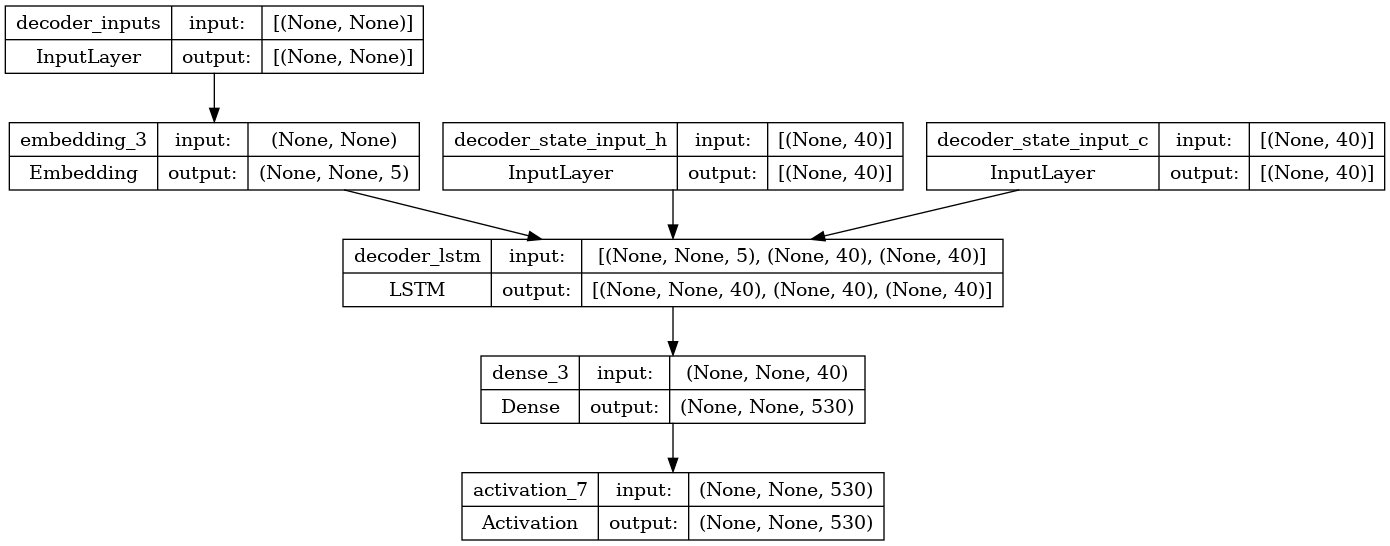

In [140]:
plot_model(decoder_model, show_shapes=True)

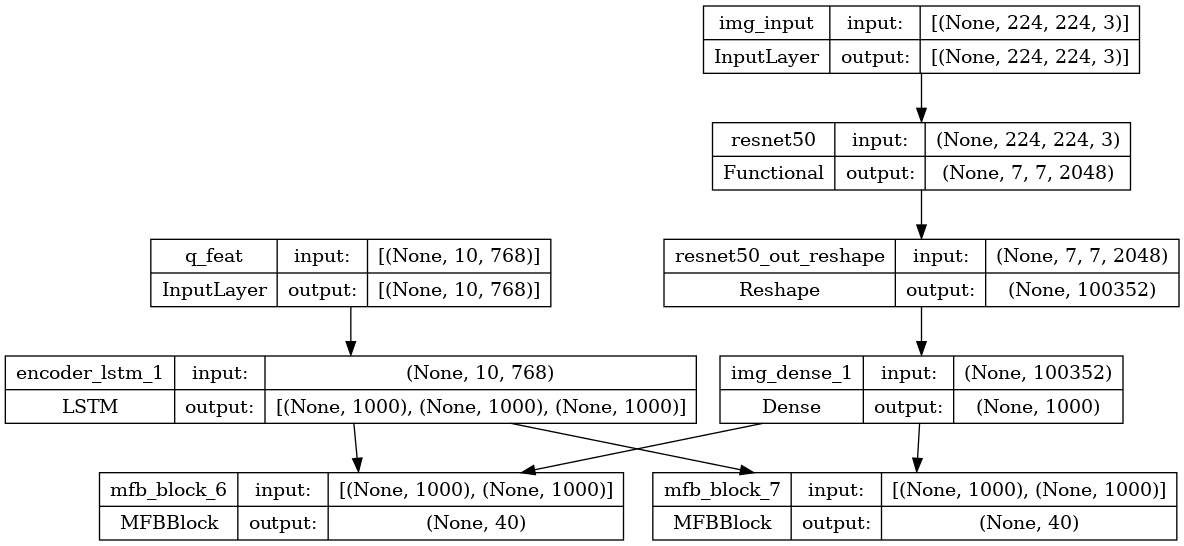

In [141]:
plot_model(encoder_model, show_shapes=True)

In [162]:
max_decoder_seq_length = 3


def get_model_res(datagen):
    preds = []
    for i in range(len(datagen)):
        enc_inp, tgt = datagen[i]
        inp, ans = enc_inp
        q, img = inp
        pred = decode_batch_sequence([q, img], encoder_model, decoder_model, batch_size=img.shape[0])
        pred = np.array(pred, dtype="str").transpose()
        preds.append(pred)
    return preds

        
def get_infer(datagen, preds, batch_size):
    infers = []
    truths = []
    scores = []
    for j in range(len(datagen)):
        pred = preds[j]
        enc_inp, tgt = datagen[j]
        inp, ans = enc_inp
        for i in range(len(pred)):
            p = (' '.join(pred[i])).replace(">", "").strip()
            t = (' '.join([itow[idx] for idx in ans[i]]).replace(">", "").replace("<", "").strip())
            s = nltk.translate.bleu_score.sentence_bleu([word_tokenize(str(t))], word_tokenize(p))
            infers.append(p)
            truths.append(t)
            scores.append(s)
    return infers, truths, scores

def decode_batch_sequence(input_seqs, encoder_model, decoder_model, batch_size):
    states_value = encoder_model.predict(input_seqs, verbose=0)
    target_seq = np.zeros((batch_size, 1)) # only have start token => length = 1
    
    target_seq[:, 0] = wtoi["<"]
    stop_condition = False
    decoded_sentences = [] #np.empty((max_decoder_seq_length, ), dtype="str")

    for i in range(max_decoder_seq_length):
      # get output
      output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
      # get the word with the highest probability
      sampled_tokens_index =  np.argmax(output_tokens[:, -1, :], axis=-1)  
      sampled_words = [itow[i] for i in sampled_tokens_index]
      decoded_sentences.append(sampled_words)
      # adding generated word to the target sequence
      target_seq = np.concatenate((target_seq, np.reshape(sampled_tokens_index, (-1, 1))), axis=1)
      # update state
      states_value = [h, c]
    return decoded_sentences

model_infers = {
    "train": [],
    "valid": [],
}
scores = {
    "train": {},
    "valid": {}
}
class InferenceCallback(tf.keras.callbacks.Callback):
    def __init__(self, epoch_start=0):
        super(InferenceCallback, self).__init__()
        self.epoch_start = epoch_start
        
    def on_epoch_end(self, epoch, logs={}):
        train_preds = get_model_res(train_datagen)
        train_infers, train_truths, train_scores = get_infer(train_datagen, train_preds, batch_size)
        scores["train"][str(epoch+self.epoch_start+1)] = train_scores
        model_infers["train"] = train_infers
        
        valid_preds = get_model_res(valid_datagen)
        valid_infers, valid_truths, valid_scores = get_infer(valid_datagen, valid_preds, batch_size)
        scores["valid"][str(epoch+self.epoch_start+1)] = valid_scores
        model_infers["valid"] = valid_infers
        print()
        print("train bleu: ", (np.sum(train_scores)/len(train_scores)))
        print("valid bleu: ", (np.sum(valid_scores)/len(valid_scores)))
        print()
        

In [146]:
histories = []

In [157]:
history = model.fit(
    x=train_datagen,
    validation_data=valid_datagen,
    epochs=epochs,
    callbacks=[InferenceCallback(0)],
    )
histories.append(history)

Epoch 1/40
14/14 [==============================] - ETA: 0s - loss: 2.5322 - acc: 0.5411
train bleu:  0.028325465950437025
valid bleu:  0.025769614861700835

14/14 [==============================] - 45s 3s/step - loss: 2.5322 - acc: 0.5411 - val_loss: 2.8777 - val_acc: 0.5042
Epoch 2/40
14/14 [==============================] - ETA: 0s - loss: 2.3997 - acc: 0.5561

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



train bleu:  0.09018557897716901
valid bleu:  0.09041218257451838

14/14 [==============================] - 46s 3s/step - loss: 2.3997 - acc: 0.5561 - val_loss: 2.6727 - val_acc: 0.5406
Epoch 3/40
14/14 [==============================] - ETA: 0s - loss: 2.2561 - acc: 0.5678
train bleu:  0.04852691328667817
valid bleu:  0.06311022686689045

14/14 [==============================] - 45s 3s/step - loss: 2.2561 - acc: 0.5678 - val_loss: 2.6321 - val_acc: 0.5462
Epoch 4/40
14/14 [==============================] - ETA: 0s - loss: 2.0738 - acc: 0.5837
train bleu:  0.061357508704780656
valid bleu:  0.06177486554828682

14/14 [==============================] - 44s 3s/step - loss: 2.0738 - acc: 0.5837 - val_loss: 2.6782 - val_acc: 0.5266
Epoch 5/40
14/14 [==============================] - ETA: 0s - loss: 1.9891 - acc: 0.5895
train bleu:  0.08867619972363465
valid bleu:  0.08718980233153291

14/14 [==============================] - 45s 3s/step - loss: 1.9891 - acc: 0.5895 - val_loss: 2.5177 - val

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



train bleu:  0.11324942648584943
valid bleu:  0.0655297728451762

14/14 [==============================] - 45s 3s/step - loss: 1.4400 - acc: 0.6718 - val_loss: 2.4855 - val_acc: 0.5798
Epoch 16/40
14/14 [==============================] - ETA: 0s - loss: 1.4708 - acc: 0.6715
train bleu:  0.11003181808723943
valid bleu:  0.049533008646994774

14/14 [==============================] - 45s 3s/step - loss: 1.4708 - acc: 0.6715 - val_loss: 2.4500 - val_acc: 0.6050
Epoch 17/40
14/14 [==============================] - ETA: 0s - loss: 1.3722 - acc: 0.6849
train bleu:  0.14793415090836626
valid bleu:  0.07184587551817591

14/14 [==============================] - 46s 3s/step - loss: 1.3722 - acc: 0.6849 - val_loss: 2.4342 - val_acc: 0.6022
Epoch 18/40
14/14 [==============================] - ETA: 0s - loss: 1.3322 - acc: 0.6895
train bleu:  0.10919138069131462
valid bleu:  0.08866257579418245

14/14 [==============================] - 45s 3s/step - loss: 1.3322 - acc: 0.6895 - val_loss: 2.5849 - v

In [163]:
history = model.fit(
    x=train_datagen,
    validation_data=valid_datagen,
    epochs=epochs,
    callbacks=[InferenceCallback(40)],
    )
histories.append(history)

Epoch 1/40
14/14 [==============================] - ETA: 0s - loss: 0.3851 - acc: 0.8795

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



train bleu:  0.5710329935489871
valid bleu:  0.2611914015167088

14/14 [==============================] - 47s 4s/step - loss: 0.3851 - acc: 0.8795 - val_loss: 2.5050 - val_acc: 0.6863
Epoch 2/40
14/14 [==============================] - ETA: 0s - loss: 0.4571 - acc: 0.8544
train bleu:  0.599812136110844
valid bleu:  0.23523450415704109

14/14 [==============================] - 46s 3s/step - loss: 0.4571 - acc: 0.8544 - val_loss: 2.3862 - val_acc: 0.6835
Epoch 3/40
14/14 [==============================] - ETA: 0s - loss: 0.3344 - acc: 0.8954
train bleu:  0.5579464882685211
valid bleu:  0.2124018261915177

14/14 [==============================] - 46s 3s/step - loss: 0.3344 - acc: 0.8954 - val_loss: 2.4214 - val_acc: 0.6863
Epoch 4/40
14/14 [==============================] - ETA: 0s - loss: 0.3360 - acc: 0.8954
train bleu:  0.5908873768307756
valid bleu:  0.22979860559987741

14/14 [==============================] - 46s 4s/step - loss: 0.3360 - acc: 0.8954 - val_loss: 2.5065 - val_acc: 0.

In [166]:
import json

with open("/kaggle/working/vqa-rad-open.json", "w") as f:
    json.dump({
        "model_infers": model_infers,
        "scores": scores
    }, f)